In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor

## Nominal Values

In [4]:
model_LSM = LinearRegression().fit(df[['LotArea']].values, df[['SalePrice']].values);
model_huber = HuberRegressor().fit(df[['LotArea']].values, df[['SalePrice']].values);

c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
predicts_LSM = model_LSM.predict(df[['LotArea']].values)
predicts_huber = model_huber.predict(df[['LotArea']].values)

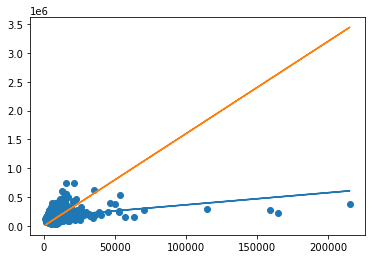

In [6]:
import matplotlib.pyplot as plt

plt.scatter(df[['LotArea']].values, df[['SalePrice']].values)
plt.plot(df[['LotArea']].values, predicts_LSM)
plt.plot(df[['LotArea']].values, predicts_huber)

In [183]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.optimize import  minimize
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.patches as mpatches
from itertools import repeat



def mapU(pair_x_c):
    #print(pair_x_c)
    x_diff = pair_x_c[0]
    c = pair_x_c[1]
    return ( 1 - (1- (x_diff / c)**2 )**3 ) if np.abs(x_diff) < c else 1


def Tukey(u, c):
    pairs = list(zip(u,  repeat(c)))
    return np.sum(list(map(mapU, pairs)))


def f(x_vec, coefs):
    return np.sum(np.dot(x_vec, coefs.T))


#Требуемая функция
def F(X, Y_true, weights = None):
    X = X.reshape(len(X), -1)
    if weights is None:
            
            X0 = np.random.normal(0, 1, size = X.shape[1] + 1)
            X0[-1] = 100000#np.abs(X0[-1])
    else:
            X0 = np.array(weights + [np.random.uniform(0, 1e6)]) 

    def Fit(coefs):        
        Y_pred = np.sum(X * coefs[:-1], axis = 1)
        diff = (Y_true - Y_pred).tolist()
        return Tukey(diff, c = coefs[-1])
    
    #Зададим исходные веса, чтобы не попасть
    #в локальный минимум, используя midhinge для порога C
    
    #Минимизируем Tukey
    bounds = [[-1e6, 1e6] for i in range(X.shape[1])] + [[0.0, 1e6]]
    res = minimize(Fit, X0, method='BFGS'
    #, bounds = bounds
    ) 
    return res 

In [184]:
coefs = F(X = df['LotArea'].values
            , Y_true = df['SalePrice'].values
            , weights= np.squeeze(model_LSM.coef_, axis = 1).tolist() #LSM Weights
            #, weights= model_huber.coef_.tolist() #Huber Weights
            )
coefs

      fun: 1.350770617749279e-14
 hess_inv: array([[ 7.86596296e-12, -8.35813978e-09],
       [-8.35813978e-09,  2.05479452e-03]])
      jac: array([0.00000000e+00, 9.78283616e-13])
  message: 'Optimization terminated successfully.'
     nfev: 66
      nit: 8
     njev: 22
   status: 0
  success: True
        x: array([ 1.95007896e+01, -7.45057859e-09])

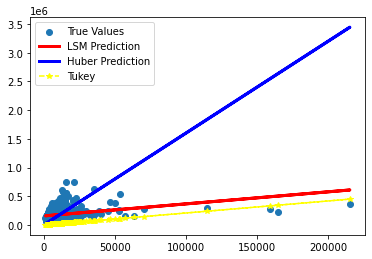

In [180]:
import matplotlib.pyplot as plt

plt.scatter(df[['LotArea']].values, df[['SalePrice']].values, label = 'True Values')
plt.plot(df[['LotArea']].values, predicts_LSM, label = 'LSM Prediction', color = 'red', linewidth = 3)
plt.plot(df[['LotArea']].values, predicts_huber, label = 'Huber Prediction', color = 'blue', linewidth = 3)
plt.plot(df[['LotArea']].values, np.sum(df[['LotArea']].values * coefs.x[:-1], axis = 1), '--*', label = 'Tukey', color = 'yellow')
plt.legend()

In [384]:
np.corrcoef(df['LotArea'].values, df['SalePrice'].values)

array([[1.        , 0.26384335],
       [0.26384335, 1.        ]])

## PolyNominal Values #1

In [375]:
df['Bias'] = 1
#X = df[['LotArea', 'Bias']].values
df['NormLotArea'] = (df['LotArea'] - df['LotArea'].mean()) / df['LotArea'].std()
X = df[['NormLotArea']].values
X = X.reshape(len(X), -1)

X = PolynomialFeatures(degree = 4, include_bias=False).fit_transform(X)[:, -1]
X = X.reshape(len(X), -1)
model_LSM = LinearRegression().fit(X, df[['SalePrice']].values);
model_huber = HuberRegressor().fit(X, df[['SalePrice']].values);

c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [376]:
model_LSM = LinearRegression().fit(X, df[['SalePrice']].values);
model_huber = HuberRegressor().fit(X, df[['SalePrice']].values);

c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [377]:
predicts_LSM = model_LSM.predict(X)
predicts_huber = model_huber.predict(X)

In [378]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.optimize import  minimize
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.patches as mpatches
from itertools import repeat


def mapU(pair_x_c):
    #print(pair_x_c)
    x_diff = pair_x_c[0]
    c = pair_x_c[1]
    return ( 1 - (1- (x_diff / c)**2 )**3 ) if np.abs(x_diff) < c else 1


def Tukey(u, c):
    pairs = list(zip(u,  repeat(c)))
    return np.sum(list(map(mapU, pairs)))


def f(x_vec, coefs):
    return np.sum(np.dot(x_vec, coefs.T))


#Требуемая функция
def F(X, Y_true, weights = None):
    X = X.reshape(len(X), -1)
    if weights is None:
            
            X0 = np.random.normal(0, 1, size = X.shape[1] + 1)
            X0[-1] = 100000#np.abs(X0[-1])
    else:
            X0 = np.array(weights + [np.random.uniform(0, 1e6)]) 

    def Fit(coefs):        
        Y_pred = np.sum(X * coefs[:-1], axis = 1)
        diff = (Y_true - Y_pred).tolist()
        return Tukey(diff, c = coefs[-1])
    
    #Зададим исходные веса, чтобы не попасть
    #в локальный минимум, используя midhinge для порога C
    
    #Минимизируем Tukey
    bounds = [[-1e6, 1e6] for i in range(X.shape[1])] + [[0.0, 1e6]]
    res = minimize(Fit, X0, method='BFGS'
    #, bounds = bounds
    ) 
    return res 

In [379]:
coefs = F(X = X
            , Y_true = df['SalePrice'].values
            , weights= np.squeeze(model_LSM.coef_, axis = 1).tolist() #LSM Weights
            #, weights= model_huber.coef_.tolist() #Huber Weights
            )
coefs

      fun: 9.265196161570529
 hess_inv: array([[3.53527095e+09, 2.42590965e+12],
       [2.42590965e+12, 1.66466381e+15]])
      jac: array([ 5.40018082e-05, -1.19209290e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 345
      nit: 32
     njev: 111
   status: 2
  success: False
        x: array([   85979.00927915, 59603703.24407982])

C:\Users\Kirill\AppData\Local\Temp\ipykernel_1352\3458491942.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  XY = np.array(sorted(list(zip(df['NormLotArea'].values, predicts_LSM)), key = lambda x: x[0]))


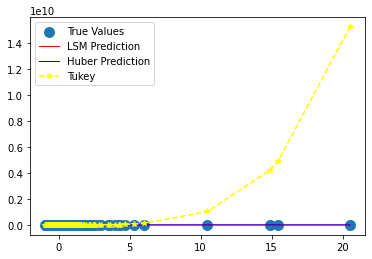

In [380]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['NormLotArea'].values, df[['SalePrice']].values, label = 'True Values', linewidths=5)

XY = np.array(sorted(list(zip(df['NormLotArea'].values, predicts_LSM)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = 'LSM Prediction', color = 'red', linewidth = 1)

XY = np.array(sorted(list(zip(df['NormLotArea'].values, predicts_huber)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = 'Huber Prediction', color = 'blue', linewidth = 1)

XY = np.array(  
                sorted(list(zip(df['NormLotArea'].values.tolist()
                            , np.sum(X * coefs.x[:-1], axis = 1)))
                    , key = lambda x: x[0])
                    )
plt.plot(XY.T[0] , XY.T[1], '--*', label = 'Tukey', color = 'yellow')
plt.legend()

C:\Users\Kirill\AppData\Local\Temp\ipykernel_1352\1542789526.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  XY = np.array(sorted(list(zip(df['NormLotArea'].values, predicts_LSM)), key = lambda x: x[0]))


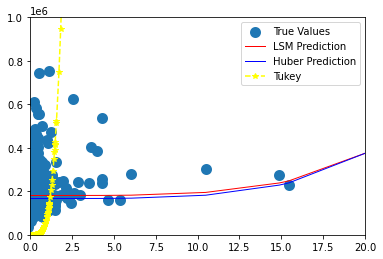

In [381]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['NormLotArea'].values, df[['SalePrice']].values, label = 'True Values', linewidths=5)

XY = np.array(sorted(list(zip(df['NormLotArea'].values, predicts_LSM)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = 'LSM Prediction', color = 'red', linewidth = 1)

XY = np.array(sorted(list(zip(df['NormLotArea'].values, predicts_huber)), key = lambda x: x[0]))
plt.plot(XY.T[0] , XY.T[1], label = 'Huber Prediction', color = 'blue', linewidth = 1)

XY = np.array(  
                sorted(list(zip(df['NormLotArea'].values.tolist()
                            , np.sum(X * coefs.x[:-1], axis = 1)))
                    , key = lambda x: x[0])
                    )
plt.plot(XY.T[0] , XY.T[1], '--*', label = 'Tukey', color = 'yellow')
plt.xlim(0, 20)
plt.ylim(0, 1e6)
plt.legend()

In [382]:
from sklearn.metrics import r2_score
print('LSM R2 ', r2_score(df[['SalePrice']].values, predicts_LSM))
print('Huber R2 ', r2_score(df[['SalePrice']].values, predicts_huber))
print('Tukey R2 ', r2_score(df[['SalePrice']].values, np.sum(X * coefs.x[:-1], axis = 1)))

LSM R2  0.005584181318851189
Huber R2  -0.024846575343902444
Tukey R2  -29791966.448799103


## PolyNominal Values

In [244]:
df['Bias'] = 1
#X = df[['LotArea', 'Bias']].values
X = df[['LotArea']].values
X = X.reshape(len(X), -1)

X = PolynomialFeatures(degree = 2, include_bias=True).fit_transform(X)

model_LSM = LinearRegression().fit(X, df[['SalePrice']].values);
model_huber = HuberRegressor().fit(X, df[['SalePrice']].values);

c:\Users\Kirill\.conda\envs\bayes\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [245]:
X

array([[7.1402500e+07],
       [9.2160000e+07],
       [1.2656250e+08],
       ...,
       [8.1757764e+07],
       [9.4420089e+07],
       [9.8743969e+07]])

In [246]:
predicts_LSM = model_LSM.predict(X)
predicts_huber = model_huber.predict(X)

In [219]:
import matplotlib.pyplot as plt
%matplotlib qt
ax = plt.figure(figsize = (10, 10)).add_subplot(projection='3d')
ax.scatter(X.T[0], X.T[1], df[['SalePrice']].values, label = 'True Points', linewidth = 5)
ax.scatter(X.T[0], X.T[1], predicts_LSM,  label = 'LSM', color = 'red', linewidth = 2)
ax.scatter(X.T[0], X.T[1], predicts_huber, label = 'Huber', color = 'blue', linewidth = 2)
ax.legend()

In [220]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.optimize import  minimize
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.patches as mpatches
from itertools import repeat


def mapU(pair_x_c):
    #print(pair_x_c)
    x_diff = pair_x_c[0]
    c = pair_x_c[1]
    return c**2 / 6 * ( 1 - (1- (x_diff / c)**2 )**3 ) if np.abs(x_diff) <= c else c**2 / 6


def Tukey(u, c):
    pairs = list(zip(u,  repeat(c)))
    return np.sum(list(map(mapU, pairs)))


def f(x_vec, coefs):
    return np.sum(np.dot(x_vec, coefs.T))


#Требуемая функция
def F(X, Y_true, weights = None):
    X = X.reshape(len(X), -1)
    if weights is None:
            
            X0 = np.random.normal(0, 1, size = X.shape[1] + 1)
            X0[-1] = 100000#np.abs(X0[-1])
    else:
            X0 = np.array(weights + [np.random.uniform(0, 1e6)]) 

    def Fit(coefs):        
        Y_pred = np.sum(X * coefs[:-1], axis = 1)
        diff = (Y_true - Y_pred).tolist()
        return Tukey(diff, c = coefs[-1])
    
    #Зададим исходные веса, чтобы не попасть
    #в локальный минимум, используя midhinge для порога C
    
    #Минимизируем Tukey
    bounds = [[-1e6, 1e6] for i in range(X.shape[1])] + [[0.0, 1e6]]
    res = minimize(Fit, X0, method='BFGS'
    #, bounds = bounds
    ) 
    return res 

In [226]:
np.squeeze(model_LSM.coef_).tolist()

[6.029026917476022, -2.7530795723969472e-05]

In [227]:
coefs = F(X = X
            , Y_true = df['SalePrice'].values
            , weights= np.squeeze(model_LSM.coef_).tolist() #LSM Weights
            #, weights= model_huber.coef_.tolist() #Huber Weights
            )
coefs

      fun: 6.727780398939418e-14
 hess_inv: array([[ 7.51515926e-10, -7.29295250e-14,  4.91733797e-07],
       [-7.29295395e-14,  7.46935650e-18, -3.71148596e-11],
       [ 4.91733797e-07, -3.71148596e-11,  2.05479475e-03]])
      jac: array([ 0.00000000e+00,  0.00000000e+00, -4.46625253e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 7
     njev: 18
   status: 0
  success: True
        x: array([-6.14196450e+00,  1.33034446e-03, -1.66278118e-08])

In [235]:

import matplotlib.pyplot as plt
%matplotlib qt
ax = plt.figure(figsize = (15, 15)).add_subplot(projection='3d')
ax.scatter(X.T[0], X.T[1], df[['SalePrice']].values, label = 'True Points', linewidth = 5)
ax.scatter(X.T[0], X.T[1], predicts_LSM,  label = 'LSM', marker = '+', color = 'red', linewidth = 2)
ax.scatter(X.T[0], X.T[1], predicts_huber, label = 'Huber', marker = '*', color = 'blue', linewidth = 2)
ax.scatter(X.T[0], X.T[1], np.sum(X * coefs.x[:-1], axis = 1), marker = '^', label = 'Tukey', color = 'purple', linewidth = 2)
ax.legend()

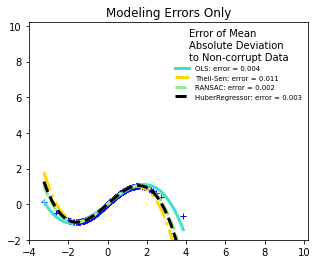

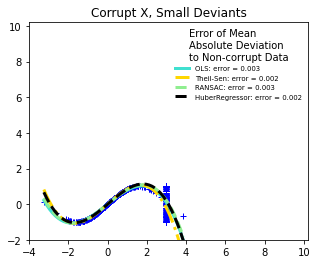

Error in callback <function flush_figures at 0x000001DD5E1C5550> (for post_execute):


KeyboardInterrupt: 

In [142]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
    ("HuberRegressor", HuberRegressor()),
]
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "HuberRegressor": "black",
}
linestyle = {"OLS": "-", "Theil-Sen": "-.", "RANSAC": "--", "HuberRegressor": "--"}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
    ("Modeling Errors Only", X, y),
    ("Corrupt X, Small Deviants", X_errors, y),
    ("Corrupt y, Small Deviants", X, y_errors),
    ("Corrupt X, Large Deviants", X_errors_large, y),
    ("Corrupt y, Large Deviants", X, y_errors_large),
]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, "b+")

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label="%s: error = %.3f" % (name, mse),
        )

    legend_title = "Error of Mean\nAbsolute Deviation\nto Non-corrupt Data"
    legend = plt.legend(
        loc="upper right", frameon=False, title=legend_title, prop=dict(size="x-small")
    )
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)

In [32]:
X = np.random.normal(size=400)
X.shape

(400,)

In [35]:
X = df[['LotArea']].values.reshape(-1, )
X.shape

(1460,)